# My Session 3

# Alternate

In [71]:
import os

import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import resize
from skimage import data

from scipy.misc import imresize
import IPython.display as ipyd

import tensorflow as tf

from libs import utils, gif, datasets, dataset_utils, vae, dft

%matplotlib inline
plt.style.use('ggplot')

## Load

In [72]:
data_directory = '../CADL/data/pokemon/jpeg/'
output_directory = './output'
experiment_title = 'jpeg-2'

In [73]:
filenames = [os.path.join(data_directory, file_i)
              for file_i in os.listdir(data_directory)
              if '.jpg' in file_i]

In [74]:
filenames = filenames
# np.random.shuffle(filenames)

nb_clip = 100
filenames = filenames[:nb_clip]
imgs = [plt.imread(f) for f in filenames]

Xs = np.array(imgs)

print(Xs.shape)

(100, 64, 64, 3)


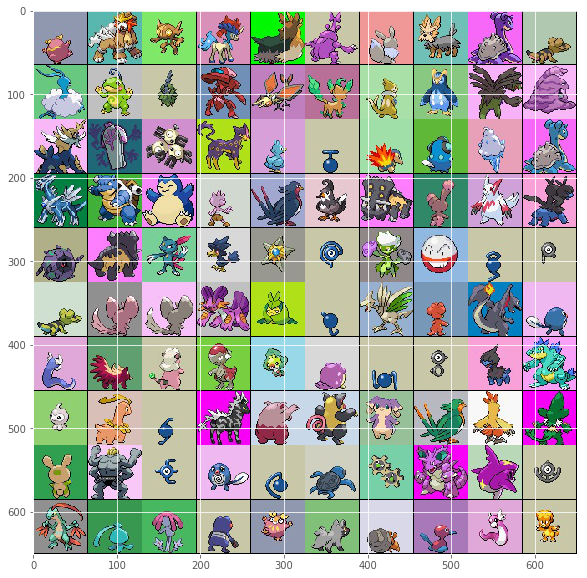

In [75]:
plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(imgs).astype(np.uint8))

In [76]:
?datasets.Dataset

In [77]:
ds = datasets.Dataset(Xs)

(64, 64, 3)


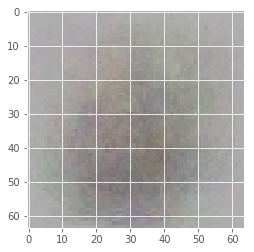

In [78]:
mean_img = ds.mean().astype(np.uint8)
plt.imshow(mean_img)
print(ds.mean().shape)

(64, 64, 3)


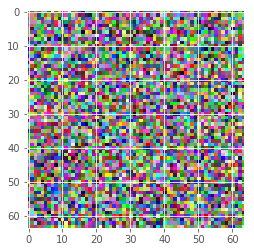

In [79]:
std_img = ds.std() #.astype(np.uint8)
plt.imshow(std_img)
print(std_img.shape)

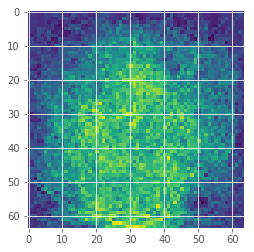

In [80]:
std_img = np.mean(std_img, axis=2)
plt.imshow(std_img)

(64, 64, 3)
(100, 64, 64, 3)


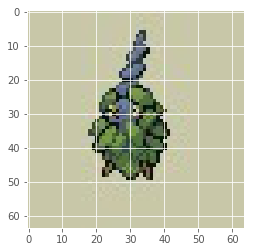

In [81]:
plt.imshow(ds.X[0])
print(ds.X[0].shape)
print(ds.X.shape)

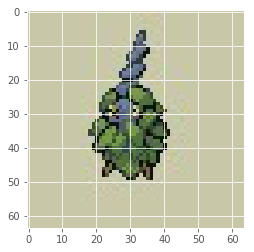

In [82]:
# Write a function to preprocess/normalize an image, given its dataset object
# (which stores the mean and standard deviation!)
def preprocess(img, ds):
    norm_img = (img - ds.mean()) / ds.std()
    return norm_img

# Write a function to undo the normalization of an image, given its dataset object
# (which stores the mean and standard deviation!)
def deprocess(norm_img, ds):
    img = norm_img * ds.std() + ds.mean()
    return img

# Just to make sure that you've coded the previous two functions correctly:
assert(np.allclose(deprocess(preprocess(ds.X[0], ds), ds), ds.X[0]))
plt.imshow(deprocess(preprocess(ds.X[0], ds), ds).astype(np.uint8))

In [83]:
# Calculate the number of features in your image.
# This is the total number of pixels, or (height x width x channels).
height = ds.X[0].shape[0]
width = ds.X[0].shape[1]
channels = ds.X[0].shape[2]

n_features = height * width * channels
print(n_features)

12288


In [84]:
print(64*64*3)

12288


In [92]:
# encoder_dimensions = [1024, 256, 64, 2]

encoder_dimensions = [1024, 64, 16, 2]
# encoder_dimensions = [1024, 64, 4]
# encoder_dimensions = [1024, 512, 256, 128, 64, 32, 16, 8]

In [99]:
tf.reset_default_graph()

In [100]:
X = tf.placeholder(tf.float32, shape = (None, n_features), name = "X")
                   
assert(X.get_shape().as_list() == [None, n_features])

In [101]:
def encode(X, dimensions, activation=tf.nn.tanh):
    # We're going to keep every matrix we create so let's create a list to hold them all
    Ws = []

    # We'll create a for loop to create each layer:
    for layer_i, n_output in enumerate(dimensions):

        # This will simply prefix all the variables made in this scope
        # with the name we give it.  Make sure it is a unique name
        # for each layer, e.g., 'encoder/layer1', 'encoder/layer2', or
        # 'encoder/1', 'encoder/2',... 
        with tf.variable_scope("encode/layer" + str(layer_i + 1)):

            # Create a weight matrix which will increasingly reduce
            # down the amount of information in the input by performing
            # a matrix multiplication.  You can use the utils.linear function.
            h, W = utils.linear(X, dimensions[layer_i])

            # Finally we'll store the weight matrix.
            # We need to keep track of all
            # the weight matrices we've used in our encoder
            # so that we can build the decoder using the
            # same weight matrices.
            Ws.append(W)
            
            # Replace X with the current layer's output, so we can
            # use it in the next layer.
            X = h
    
    z = X
    return Ws, z

In [102]:
# Then call the function
Ws, z = encode(X, encoder_dimensions)

# And just some checks to make sure you've done it right.
# assert(z.get_shape().as_list() == [None, 2])
# assert(len(Ws) == len(encoder_dimensions))

In [103]:
# We'll first reverse the order of our weight matrices
decoder_Ws = Ws[::-1]

# then reverse the order of our dimensions
# appending the last layers number of inputs.
decoder_dimensions = encoder_dimensions[::-1][1:] + [n_features]
print(decoder_dimensions)

assert(decoder_dimensions[-1] == n_features)

[16, 64, 1024, 12288]


In [104]:
def decode(z, dimensions, Ws, activation=tf.nn.tanh):
    current_input = z
    for layer_i, n_output in enumerate(dimensions):
        # we'll use a variable scope again to help encapsulate our variables
        # This will simply prefix all the variables made in this scope
        # with the name we give it.
        with tf.variable_scope("decoder/layer/{}".format(layer_i)):

            # Now we'll grab the weight matrix we created before and transpose it
            # So a 3072 x 784 matrix would become 784 x 3072
            # or a 256 x 64 matrix, would become 64 x 256
            W = tf.transpose(Ws[layer_i])

            # Now we'll multiply our input by our transposed W matrix
            h = tf.matmul(current_input, W)

            # And then use a relu activation function on its output
            current_input = activation(h)

            # We'll also replace n_input with the current n_output, so that on the
            # next iteration, our new number inputs will be correct.
            n_input = n_output
    Y = current_input
    return Y

In [105]:
Y = decode(z, decoder_dimensions, decoder_Ws)

In [106]:
Y.get_shape().as_list()

[None, 12288]

In [107]:
# Calculate some measure of loss, e.g. the pixel to pixel absolute difference or squared difference
loss = tf.squared_difference(X, Y)

# Now sum over every pixel and then calculate the mean over the batch dimension (just like session 2!)
# hint, use tf.reduce_mean and tf.reduce_sum
cost = tf.reduce_sum(loss)

In [108]:
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [109]:
from libs import tboard
tboard.show_graph(tf.get_default_graph().as_graph_def())

Instructions for updating:
Use `tf.global_variables_initializer` instead.
0 122.9998125


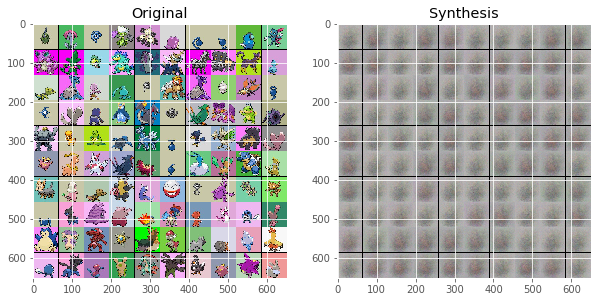

1 115.782275
2 107.569175
3 101.13555
4 97.610675
5 96.2760875
6 94.18440625
7 91.70159375
8 88.54318125
9 87.2817375
10 87.42956875


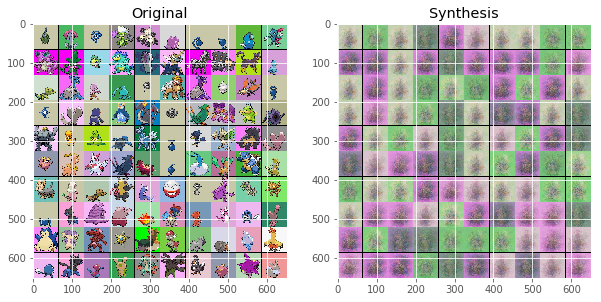

11 88.1367
12 89.0124875
13 89.30339375
14 88.75221875
15 87.6436125
16 86.48374375
17 86.05939375
18 86.4689625
19 87.10239375
20 86.61624375


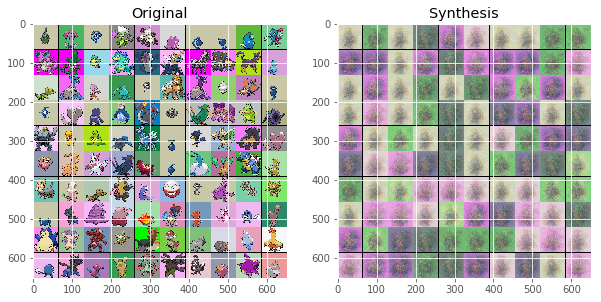

21 85.73009375
22 85.14885
23 85.02128125
24 85.30675625
25 85.31228125
26 85.383375
27 85.2484
28 85.094
29 84.7623125
30 84.31994375


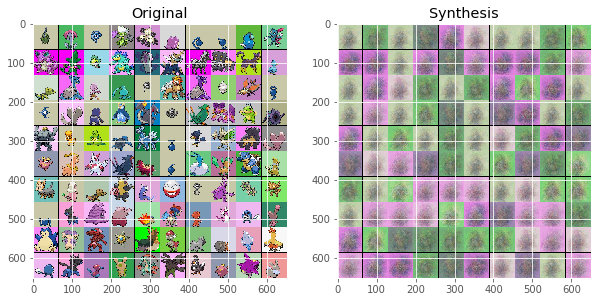

31 84.1501875
32 84.52539375
33 84.837475
34 84.73366875
35 84.61670625
36 84.42685
37 84.1298125
38 83.70491875
39 83.32909375
40 83.17053125


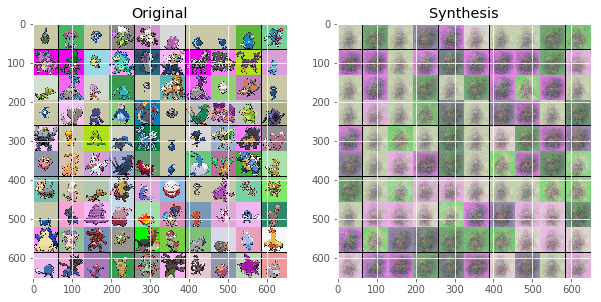

41 83.37268125
42 83.76909375
43 84.36118125
44 84.63580625
45 84.6936125
46 84.29539375
47 83.64183125
48 83.09476875
49 82.4979
50 82.1807


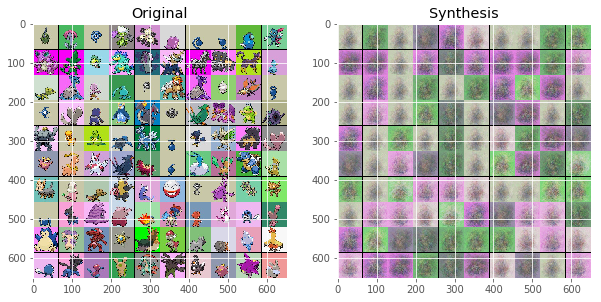

51 81.9346125
52 82.2167125
53 82.5353875
54 82.23893125
55 81.85215
56 81.4845375
57 81.37019375
58 81.31706875
59 81.5633875
60 81.532675


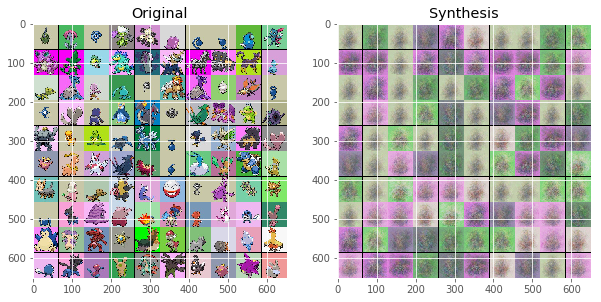

61 81.71240625
62 81.6373125
63 81.58993125
64 81.42115
65 81.1551625
66 80.7645375
67 80.66810625
68 80.7492625
69 80.732325
70 80.59835


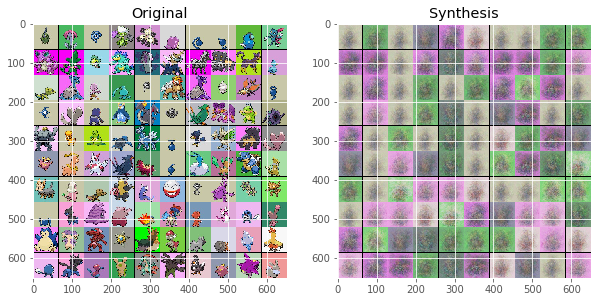

71 80.50063125
72 80.49866875
73 80.37431875
74 80.36069375
75 80.3129625
76 80.210175
77 80.3057625
78 80.2746375
79 80.26055
80 80.27089375


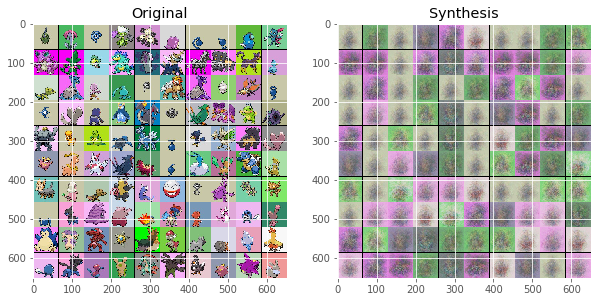

81 80.16968125
82 80.1008125
83 80.02316875
84 79.9420125
85 79.8592625
86 80.18341875
87 80.66134375
88 80.79758125
89 80.74919375
90 80.5733


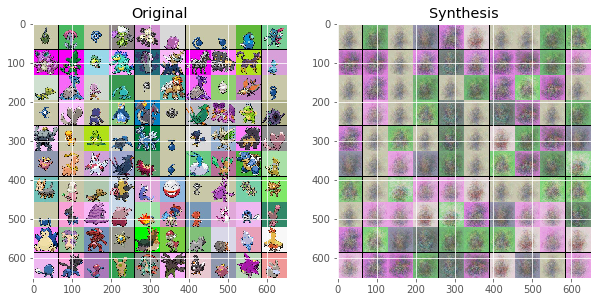

91 80.043675
92 80.145
93 80.95095625
94 82.276375
95 82.715025
96 83.37551875
97 83.11346875
98 82.57149375
99 82.38191875
100 82.1217375


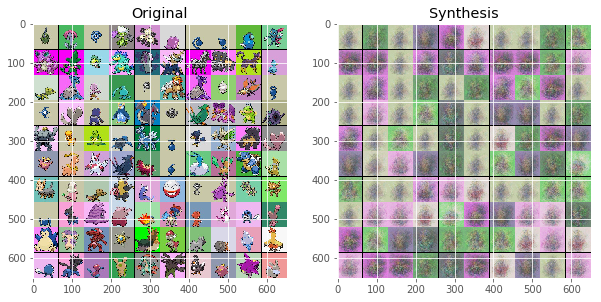

101 81.91055625
102 81.70753125
103 81.4692125
104 81.1630875
105 81.0426
106 80.7796625
107 81.1130125
108 81.63831875
109 83.05315625
110 83.06045


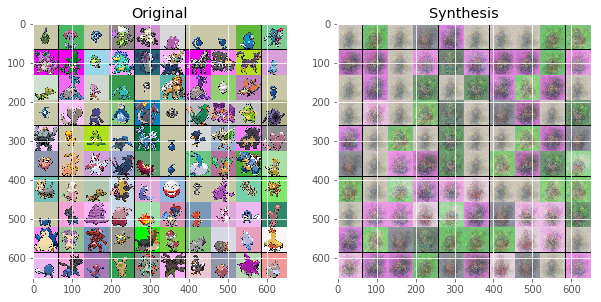

111 82.2662
112 81.819225
113 82.04269375
114 81.53825
115 82.8913625
116 82.05335625
117 82.3098
118 82.977025
119 85.19405625
120 84.17181875


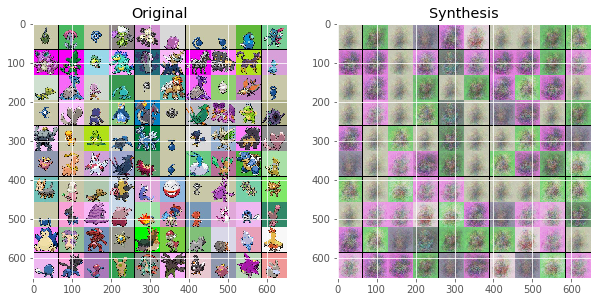

121 82.7703375
122 82.5455375
123 83.67049375
124 86.45808125
125 89.1500375
126 90.1189
127 90.7825
128 90.874775
129 90.87936875
130 90.78805


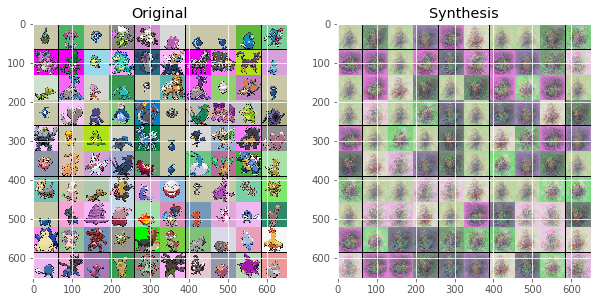

131 90.52223125
132 89.7258625
133 88.7430875
134 87.89803125
135 87.10715625
136 86.61503125
137 86.29818125
138 86.25780625
139 85.7141125
140 85.6266


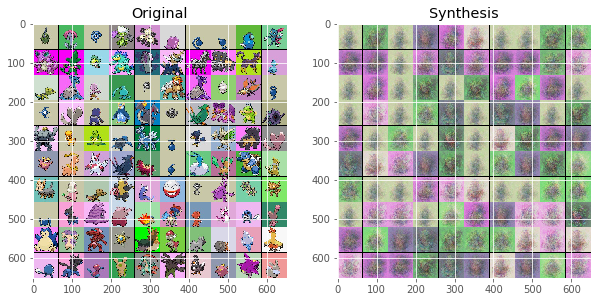

141 84.72075
142 85.351375
143 85.840275
144 87.45418125
145 87.99979375
146 87.40680625
147 87.4975625
148 86.85045
149 86.18644375
150 85.8004125


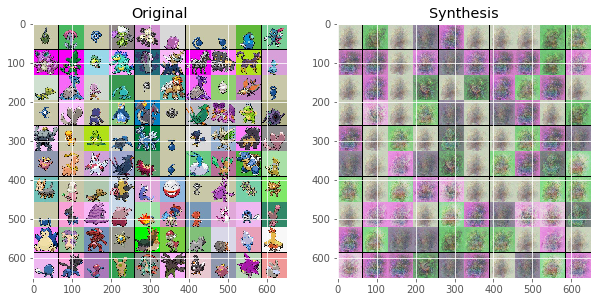

In [110]:
# Create a tensorflow session and initialize all of our weights:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

# Some parameters for training
batch_size = 100
n_epochs = 151
step = 10

# We'll try to reconstruct the same first 100 images and show how
# The network does over the course of training.
examples = ds.X[:100]

# We have to preprocess the images before feeding them to the network.
# I'll do this once here, so we don't have to do it every iteration.
test_examples = preprocess(examples, ds).reshape(-1, n_features)

# If we want to just visualize them, we can create a montage.
test_images = utils.montage(examples).astype(np.uint8)

# Store images so we can make a gif
gifs = []

# Now for our training:
for epoch_i in range(n_epochs):
    
    # Keep track of the cost
    this_cost = 0
    
    # Iterate over the entire dataset in batches
    for batch_X, _ in ds.train.next_batch(batch_size = batch_size):
        
        # Preprocess and reshape our current batch, batch_X:
        this_batch = preprocess(batch_X, ds).reshape(-1, n_features)
        
        # Compute the cost, and run the optimizer.
        this_cost += sess.run([cost, optimizer], feed_dict = {X: this_batch})[0]
    
    # Average cost of this epoch
    avg_cost = this_cost / ds.X.shape[0] / batch_size
    print(epoch_i, avg_cost)
    
    # Let's also try to see how the network currently reconstructs the input.
    # We'll draw the reconstruction every `step` iterations.
    if epoch_i % step == 0:
        
        # Ask for the output of the network, Y, and give it our test examples
        recon = sess.run(Y, feed_dict = {X: test_examples})
                         
        # Resize the 2d to the 4d representation:
        rsz = recon.reshape(examples.shape)

        # We have to unprocess the image now, removing the normalization
        unnorm_img = deprocess(rsz, ds)
                         
        # Clip to avoid saturation
        clipped = np.clip(unnorm_img, 0, 255)

        # And we can create a montage of the reconstruction
        recon = utils.montage(clipped).astype(np.uint8)
        
        # Store for gif
        gifs.append(recon)

        fig, axs = plt.subplots(1, 2, figsize=(10, 10))
        axs[0].imshow(test_images)
        axs[0].set_title('Original')
        axs[1].imshow(recon)
        axs[1].set_title('Synthesis')
        fig.canvas.draw()
        plt.show()

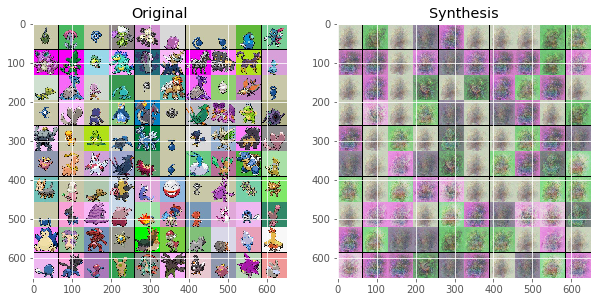

In [111]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(test_images)
axs[0].set_title('Original')
axs[1].imshow(recon)
axs[1].set_title('Synthesis')
fig.canvas.draw()
plt.show()
plt.imsave(arr=test_images, fname=os.path.join(output_directory, experiment_title + '-pokemon-test-4.png'))
plt.imsave(arr=recon, fname=os.path.join(output_directory, experiment_title +'-pokemon-recon-4.png'))

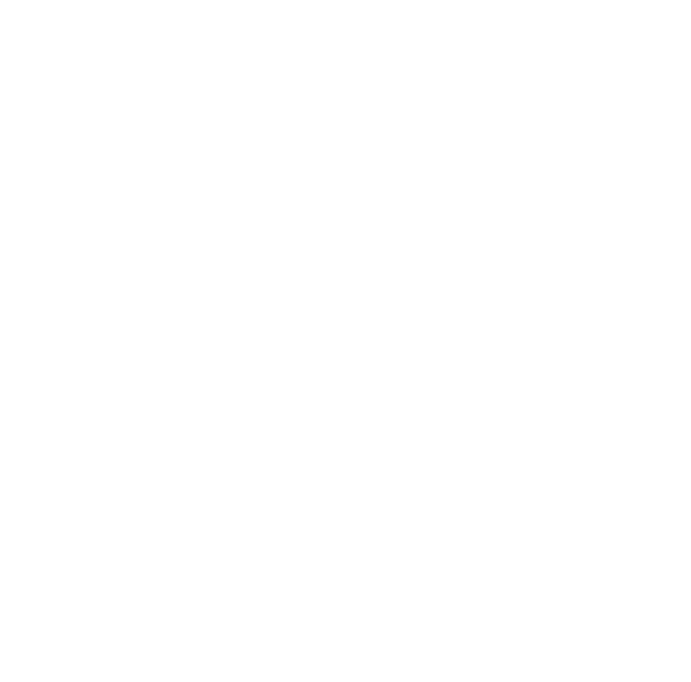

In [113]:
gif.build_gif(gifs, interval=0.2, saveto=os.path.join(output_directory, experiment_title +'-reconstruction.gif'))
ipyd.Image(url=os.path.join(output_directory, experiment_title +'-reconstruction.gif?{}').format(np.random.rand()),
           height=500, width=500)